# **Programming Assignment 5: Deep k-Means: Jointly clustering with k-Means and learning representations**

This exercise implements the [DKM](https://arxiv.org/pdf/1806.10069.pdf) approach. The method study the problem of jointly clustering and learning representations.

**Assumption**: Learning representations that are both faithful to the data to be clustered and adapted to the clustering algorithm can lead to better clustering performance, all the more so that the two tasks are performed jointly.

## Deep k-Means variants

In the experiments, we considered two variants of this approach: the **Annealing** and the **Pretrained**.

**DKMa** implements an **annealing** strategy for $\alpha$ and does not rely on pretraining. In the scheme, the evolution of the $\alpha$ is given by the following recursive sequence:

$\alpha_{n+1}= 2^{1/log(n)^2} ×\alpha_n$ with $m_\alpha = \alpha_1= 0.1$

The rationale behind the choice of this scheme is that we want alpha to spend more iterations on smaller values and less on larger values while preserving a gentle slope.

**DKMp** variant is initialized by first pretraining an auto-encoder and then applying the jointly clustering approach with a constant $\alpha$ such that $m_\alpha = M_\alpha= 1000$. Such a high $\alpha$ is equivalent to having hard cluster assignments.

###**Code**

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1 import keras
import argparse
import seaborn as sns
import numpy as np
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input
from sklearn.cluster import KMeans
!pip install visualkeras
import visualkeras
from tensorflow.compat.v1.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.compat.v1.keras import backend as K
import sklearn.metrics as metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 5.5 MB/s eta 0:00:00


###**Load dataset**

Image dataset consist of MNIST (70,000 images, 28×28 pixels, 10 classes) containing hand-written digit images.

11490434/11490434 [==============================] - 0s 0us/step
MNIST samples (70000, 784)


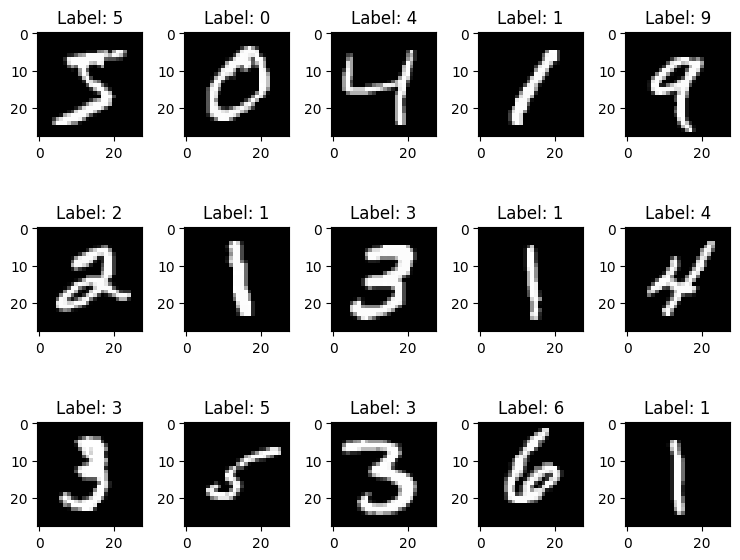

In [ ]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    # reshape x to (70000, 28*28)
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('MNIST samples', x.shape)

    num = 15
    images = x_train[:num]
    labels = y_train[:num]
    num_row = 3
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

    return x, y

x, y = load_mnist()

###**Funções Gerais**

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels = None, batch_size = 64, dim = 28, n_classes=10,
                 samp_per_epoch = None, shuffle=False, flag_AE = False):
        '''
        Parameters
        ----------
        data : image stack with shape (row, col, channels*seq)
        labels : labels stack with shape (row, col, seq)
        coords : x,y coordinate for each pixel of interest
        idx_coord : index of coordinates, shape (len(coords),2)
        channels : channels of imput data for each seq. The default is 14.
        patch_size : patch size. The default is 15.
        batch_size : The default is 32.
        dim : input dimension for the CNN model. The default is (15,15,14).
        n_classes : number of classes. The default is 4.
        samp_per_epoch : (optional) # of samples for each epoch. The default is None.
        shuffle : (optional) shuffle after each epoch. The default is False.
        use_augm : (optional) data augmenattion. The default is False.

        Returns
        -------
            Datagenerator

        '''
        self.data = data
        self.label = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.samp_per_epoch = samp_per_epoch
        self.flag_AE = flag_AE
        self.list_IDs = np.arange(len(self.data))

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.samp_per_epoch:
            # train over #samp_per_epoch random samples at each epoch
            return int(np.ceil(self.samp_per_epoch / self.batch_size))
        else:
            # use all avaliable samples at each epoch
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index+1)*self.batch_size > len(self.indexes):
            indexes = self.indexes[index*self.batch_size:]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        idx_tmp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.__data_generation(idx_tmp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes and list coords after each epoch'
        if self.samp_per_epoch:
            self.indexes = np.arange(self.samp_per_epoch)
        else:
            self.indexes = np.arange(len(self.list_IDs))

        if self.shuffle == True:
            # shuffle indexes we use to iterate on
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((len(idx_tmp), self.dim*self.dim))

        X = self.data[idx_tmp]

        if self.flag_AE:
            return X, X

        return X, [X, np.ones((len(idx_tmp)))]


def make_autoencoder(dims, act='relu'):
        """
        Fully connected auto-encoder model, symmetric.
        Arguments:
            dims: list of number of units in each layer d-500-500-2000-K,
                  where d is the original data space dimension and K is the number
                  of clusters to obtain.
                  The decoder is symmetric with encoder.
        return:
            Model of autoencoder
        """
        n_stacks = len(dims) - 1
        # input
        x = Input(shape=(dims[0],), name='input')
        h = x

        # internal layers in encoder
        for i in range(n_stacks-1):
            h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

        # hidden layer
        encoder_layer = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            if i == n_stacks-1:
                h = encoder_layer
            h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

        # output
        h = Dense(dims[0], name='AE_')(h)

        encoder = Model(inputs=x, outputs=encoder_layer)
        autoencoder = Model(inputs=x, outputs=h)

        return autoencoder,encoder

# Reconstruction Loss
def g_func(x, x_):
   return tf.reduce_sum(tf.square(x - x_), axis=1)

def Loss_AE():
    """The AE network is trained by minimizing the reconstruction error,
    L(x,x^), which measures the differences between our original input and
    the consequent reconstruction. """
    def loss(y_true, y_pred):
        rec_error = g_func(y_true, y_pred)
        ae_loss = tf.reduce_mean(rec_error)
        return ae_loss
    return loss


def f_func(h, rk):
   return tf.reduce_sum(tf.square(h - rk), axis=1)

class DistanceLayer(Layer):
    """ Layer which calculates the distance from each point to all centroids"""

    def __init__(self, n_clusters, weights=None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DistanceLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer, name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ## Compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, self.n_clusters):
            dist = f_func(inputs, self.clusters[i:i+1, :])
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        return tf.transpose(self.stack_dist)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(DistanceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class  Softmax_function(Layer):
    """ Layer which calculates the softmax function from the distance
    of the samples to the centroids"""

    def __init__(self, n_clusters, weights=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Softmax_function, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.alpha = self.add_weight(shape=(1,), initializer='glorot_uniform', name='alpha')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True


    def call(self, dists, **kwargs):

        dists = tf.transpose(dists)
        # Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(dists, axis=0)
        # Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        list_exp = []
        for i in range(self.n_clusters):
            exp = tf.exp(-self.alpha * (dists[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)
        # print(sum_exponentials.get_shape().as_list())
        #Compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(self.n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = dists[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        stack_weighted_dist = tf.transpose(stack_weighted_dist)
        return stack_weighted_dist

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0],

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(Softmax_function, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Loss_Clustering(lambda_):

    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.reduce_sum(tf.transpose(y_pred), axis=0)) * lambda_

    return loss

###**Funções de Treinamento**

In [ ]:
def pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE=10):
    # Step 1: Pretrain the autoencoder
    autoencoder.compile(optimizer=optimizer, loss=Loss_AE())

    training_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                       samp_per_epoch=None, shuffle=True, flag_AE=True)

    # Train model on dataset
    history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)

    # Step 2: Initialize cluster centers using k-means
    print('Initializing cluster centers with k-means')
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++")

    AE_generator = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10,
                                 samp_per_epoch=None, shuffle=False, flag_AE=True)

    print('Extract Features')
    extract_features = encoder.predict_generator(AE_generator, verbose=1)

    y_pred = kmeans.fit_predict(extract_features)

    return y_pred, kmeans

def create_deep_clustering_model(autoencoder, n_stacks, n_clusters):
    hidden = autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
    encoder = Model(inputs=autoencoder.input, outputs=hidden)

    distance_layer = DistanceLayer(n_clusters=n_clusters, name='distance')(hidden)
    softmax_function = Softmax_function(n_clusters, trainable=False, name='clustering')(distance_layer)

    Deep_km = Model(inputs=encoder.input, outputs=[autoencoder.output, softmax_function])
    model_see = Model(inputs=encoder.input, outputs=softmax_function)

    return Deep_km, model_see,distance_layer

def train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans=None, num_epochs_per_alpha=1, pre_train=False):
    if pre_train and kmeans is not None:
        Deep_km.get_layer(name='distance').set_weights([kmeans.cluster_centers_])

    deep_kmeans_gen = DataGenerator(x, labels=None, batch_size=256, dim=dims[0], n_classes=10, samp_per_epoch=None, shuffle=True)

    for k in range(len(alphas)):
        print("Training step: alpha[{}]: {}".format(k, alphas[k]))

        Deep_km.get_layer(name='clustering').set_weights([alphas[k:k+1]])

        print(Deep_km.get_layer(name='clustering').get_weights()[0].reshape((-1))[0])

        history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)

    Deep_km_predictor = Model(inputs=Deep_km.input, outputs=Deep_km.get_layer(name='distance').output)

    AE_generator = DataGenerator(x, None, batch_size=256, dim=dims[0], n_classes=10, shuffle=False)

    extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)

    y_pred = np.argmin(extract_feat, axis=1)

    return y_pred

## Parâmetros e Treinamento

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
n_stacks = len(dims) - 1
autoencoder,encoder = make_autoencoder(dims)

In [ ]:
optimizer= Adam(learning_rate=1e-3)
n_clusters = 10
lambda_ = 1
num_epochs_AE = 50

Pre-train Scheme Done!


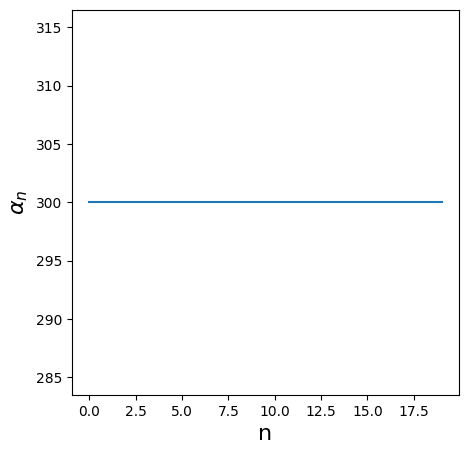

In [ ]:
#################### CODE HERE ################################

Pre_train = True
Annealing = False

#Alpha Parameter
if Annealing and not Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 40  # Number of alpha values to consider
    alphas = np.zeros(max_n, dtype=float)
    alphas[0] = 0.1
    for i in range(1, max_n):
        alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
    alphas = alphas / constant_value
    print("Annealing Scheme Done!")

elif not Annealing and Pre_train:

    constant_value = 1  # Used to modify the range of the alpha scheme
    max_n = 20  # Number of alpha values to consider
    alpha = 300
    alphas = alpha*np.ones(max_n, dtype=float) # alpha is constant
    alphas = alphas / constant_value
    print("Pre-train Scheme Done!")

plt.figure(figsize=(5,5))
plt.plot(np.arange(max_n),alphas)
plt.xlabel('n',fontsize = 16); plt.ylabel(r'$\alpha_n$',fontsize = 16);

In [ ]:
Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)
model_see.summary()
Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

if Pre_train:
  y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans)
else:

  y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-5-ce2c7326a071>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 6s 7ms/step - loss: 29.1081
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 16.9868
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 14.9504
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 13.7898
Epoch 5/50
274/274 [==============================] - 1s 5ms/step - loss: 13.0330
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 12.5065
Epoch 7/50
274/274 [==============================] - 2s 7ms/step - loss: 12.0381
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.6236
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.3399
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 11.0404
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.8159
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.5803
Epoch 13/50
274/274 [===

<ipython-input-5-ce2c7326a071>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-5-ce2c7326a071>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 10ms/step - loss: 9.6925 - AE__loss: 8.2740 - clustering_loss: 1.4185
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.9112 - AE__loss: 8.1841 - clustering_loss: 0.7271
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 13ms/step - loss: 8.5821 - AE__loss: 8.0405 - clustering_loss: 0.5417
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 3s 9ms/step - loss: 8.4020 - AE__loss: 7.9584 - clustering_loss: 0.4436
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 3s 9ms/step - loss: 8.2997 - AE__loss: 7.9201 - clustering_loss: 0.3796
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 11ms/step - loss: 8.1907 - AE__loss: 7.8567 - clustering_loss: 0.3340
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 8.1143 - AE__loss: 7

<ipython-input-5-ce2c7326a071>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


## **Evaluation Metrics**

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment

def assignment_cluster(y_true, y_pred):

    w = np.zeros((y_pred.max() + 1, y_true.max() + 1), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)

    aux = np.zeros_like(y_pred)
    for i in range(len(ind[0])):
        aux[y_pred == ind[0][i]] = ind[1][i]
    y_pred_map = aux

    return y_pred_map

# print(y_pred)
# y_pred_map = assignment_cluster(y, y_pred)
# print(y_pred_map)

In [ ]:
def calculate_evaluation_metrics(y_true, y_pred):
    # Calcular as métricas
    acc = np.round(metrics.accuracy_score(y_true, y_pred), 5)
    nmi = np.round(metrics.normalized_mutual_info_score(y_true, y_pred), 5)
    f1score = 100 * metrics.f1_score(y_true, y_pred, average=None)

    # Retornar as métricas
    return acc, nmi, f1score

def plot_f1_score_per_class(f1score):
    # Configuração para o gráfico de barras
    classes = np.arange(len(f1score))  # as classes são numeradas de 0 a len(f1score) - 1
    width = 0.35

    # Criar o gráfico de barras
    fig, ax = plt.subplots()
    rects1 = ax.bar(classes, f1score, width, label='Digits')

    # Adicionar rótulos e título ao gráfico
    ax.set_ylabel('Scores', fontsize=15)
    ax.set_xlabel('Digits', fontsize=15)
    ax.set_title('F1 score per class', fontsize=15)
    ax.set_xticks(classes)
    ax.legend()

    # Ajustar o layout e exibir o gráfico
    fig.tight_layout()
    plt.show()



def plot_confusion_heatmap(y_true, y_pred, classes=None, figsize=(6, 6)):
    """
    Plota um heatmap da matriz de confusão normalizada.

    Parâmetros:
    - y_true: Rótulos verdadeiros.
    - y_pred: Rótulos previstos.
    - classes: Lista de classes (opcional).
    - figsize: Tamanho da figura (largura, altura).
    """
    if classes is None:
        classes = np.unique(y_true)

    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm, decimals=2)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, cbar=False, cmap="YlGnBu", linewidths=.5, linecolor='black')

    plt.title('Accuracy: ' + str(np.round(metrics.accuracy_score(y_true, y_pred), decimals=2)), fontsize=16)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.show()


In [ ]:
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


###**Task 1**: Train the Deep k Means with different modes and alpha values, and discuss the impact of the parameters on the cluster results. Discuss also the impact on different classes.

| Configuration       | **$\alpha$**-Pretrained    | **$\alpha$**-Annealing  |**Accuracy**  |
| :-----------:        | :-----------: | :---------: |:---------: |
| 1                    |         | $\alpha_0$=0.01     ||
| 2                    |         |  $\alpha_0$=0.1      ||
| 3                    |        |  $\alpha_0$=0.5       ||
| 4                    |        | $\alpha_0$=1       ||
| 5                    | $\alpha_n$=3        |       ||
| 6                    |   $\alpha_n$= 30      |      ||
| 7                    |  $\alpha_n$= 150        |      ||
| 8                    |   $\alpha_n$=   300     |      ||

###**Task 2**: Vary the number of clusters for the best result configuration: 2, 5, 10, 20. Comment on how the clusters group the classes and show examples of images and/or the original classes distribution in each cluster to justify the discussion.

## TASK 1


### Funções auxiliares

In [ ]:
def get_alphas(m_alpha: float, pre_train=False):
    if not pre_train:
        constant_value = 1  # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = m_alpha
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif pre_train:
        constant_value = 1  # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider
        alpha = m_alpha
        alphas = alpha*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    return alphas


In [ ]:
def train_pipeline(m_alpha, pre_train=False, n_clusters=10):
    autoencoder, encoder = make_autoencoder(dims)
    alphas = get_alphas(m_alpha, pre_train)

    Deep_km, model_see,distance_layer = create_deep_clustering_model(autoencoder, n_stacks, n_clusters)

    model_see.summary()
    Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])

    if pre_train:
        y_pred, kmeans = pretrain_and_kmeans(x, autoencoder, encoder, n_clusters, optimizer, num_epochs_AE)
        y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer, kmeans, pre_train=pre_train)
    else:
        y_pred = train_deep_clustering_model(Deep_km, alphas, x, optimizer)

    return y_pred


### Config. 1

In [ ]:
y_pred = train_pipeline(0.01, False)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-5-b3928d39f01c>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 11s 10ms/step - loss: 36.7726 - AE__loss: 34.1869 - clustering_loss: 2.5856
Training step: alpha[1]: 0.04232086106557082
0.042320862
274/274 [==============================] - 3s 10ms/step - loss: 20.5328 - AE__loss: 19.3218 - clustering_loss: 1.2110
Training step: alpha[2]: 0.07515684111296622
0.07515684
274/274 [==============================] - 3s 11ms/step - loss: 17.3810 - AE__loss: 16.7920 - clustering_loss: 0.5890
Training step: alpha[3]: 0.10779711601958948
0.107797116
274/274 [==============================] - 3s 11ms/step - loss: 15.7990 - AE__loss: 15.4684 - clustering_loss: 0.3306
Training step: alpha[4]: 0.1408711011578593
0.14087111
274/274 [==============================] - 3s 10ms/step - loss: 14.8061 - AE__loss: 14.5763 - clustering_loss: 0.2297
Training step: alpha[5]: 0.1748191408588925
0.17481914
274/274 [==============================] - 3s 12ms/step - loss: 14.1078 - AE__loss: 13.9165 - clustering_loss: 0.1913
Training st

<ipython-input-5-b3928d39f01c>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 5ms/step


Acc = 0.27873, NMI = 0.29185


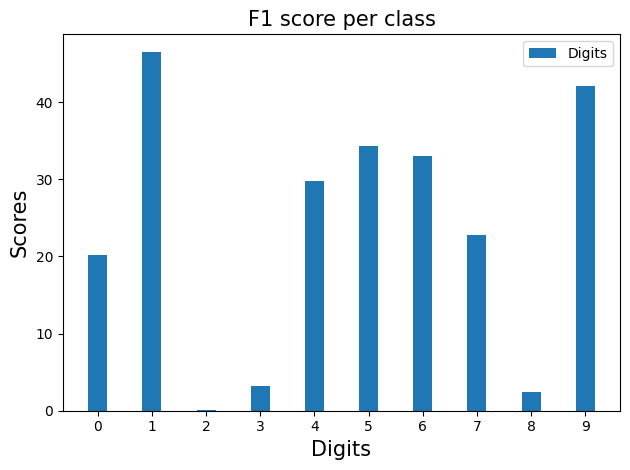

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

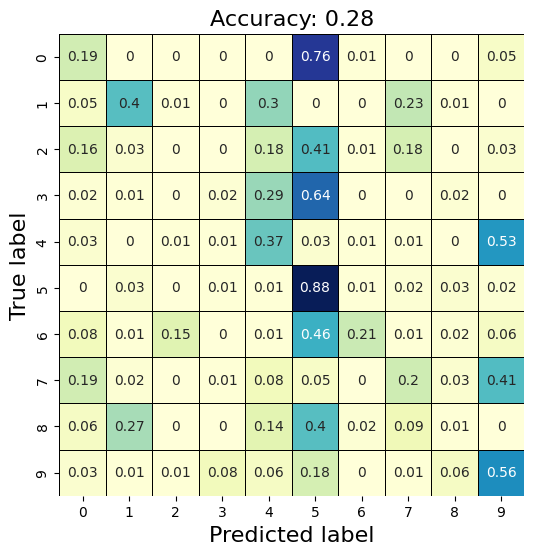

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 2

In [ ]:
y_pred = train_pipeline(0.1, False)

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-21-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 7s 10ms/step - loss: 52.3455 - AE__loss: 50.5427 - clustering_loss: 1.8028
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 3s 12ms/step - loss: 35.6657 - AE__loss: 35.3935 - clustering_loss: 0.2722
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 4s 13ms/step - loss: 31.1117 - AE__loss: 30.9166 - clustering_loss: 0.1950
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 3s 10ms/step - loss: 28.0892 - AE__loss: 27.9149 - clustering_loss: 0.1743
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 10ms/step - loss: 25.8849 - AE__loss: 25.7252 - clustering_loss: 0.1597
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 4s 15ms/step - loss: 24.4157 - AE__loss: 24.2631 - clustering_loss: 0.1526
Training step: alpha[

<ipython-input-21-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.59633, NMI = 0.57047


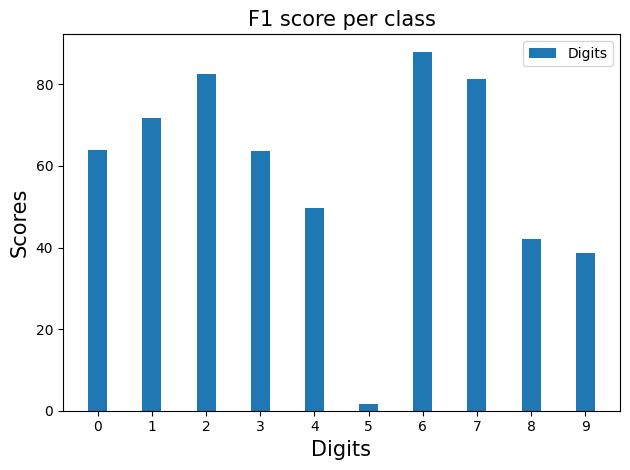

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

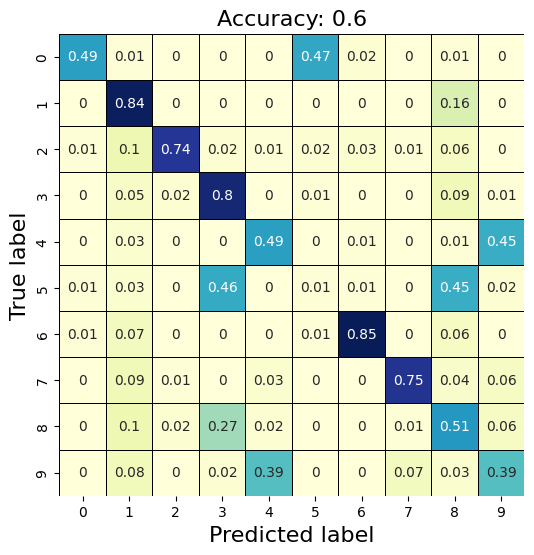

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 3

In [ ]:
y_pred = train_pipeline(0.5, False)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1   

<ipython-input-4-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 11s 16ms/step - loss: 37.2725 - AE__loss: 35.9040 - clustering_loss: 1.3685
Training step: alpha[1]: 2.116043053278541
2.116043
274/274 [==============================] - 3s 11ms/step - loss: 21.5096 - AE__loss: 21.0156 - clustering_loss: 0.4940
Training step: alpha[2]: 3.7578420556483114
3.757842
274/274 [==============================] - 3s 10ms/step - loss: 18.7412 - AE__loss: 18.3905 - clustering_loss: 0.3507
Training step: alpha[3]: 5.389855800979475
5.389856
274/274 [==============================] - 4s 13ms/step - loss: 17.3332 - AE__loss: 17.0372 - clustering_loss: 0.2959
Training step: alpha[4]: 7.043555057892966
7.0435553
274/274 [==============================] - 3s 10ms/step - loss: 16.3566 - AE__loss: 16.0929 - clustering_loss: 0.2638
Training step: alpha[5]: 8.740957042944627
8.740957
274/274 [==============================] - 3s 10ms/step - loss: 15.5680 - AE__loss: 15.3287 - clustering_loss: 0.2393
Training step: alpha[6]: 10.4

<ipython-input-4-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 2s 3ms/step


Acc = 0.30629, NMI = 0.47233


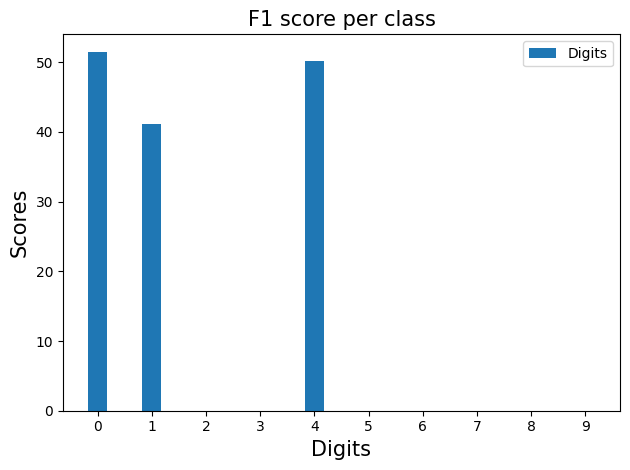

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

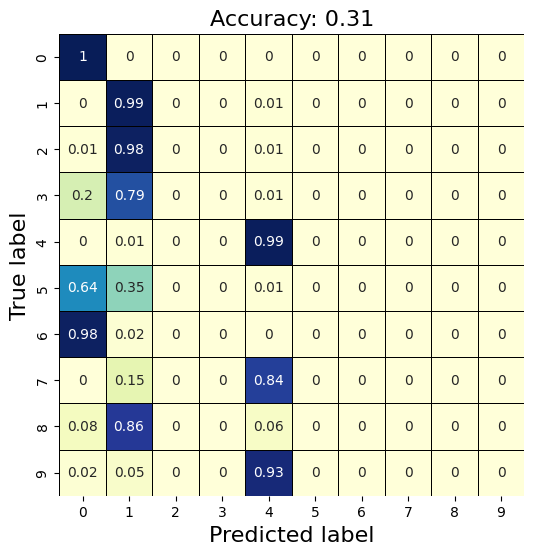

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 4

In [ ]:
y_pred = train_pipeline(1, False)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-4-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 10ms/step - loss: 53.9769 - AE__loss: 52.7226 - clustering_loss: 1.2543
Training step: alpha[1]: 4.232086106557082
4.232086
274/274 [==============================] - 4s 15ms/step - loss: 40.1244 - AE__loss: 40.0058 - clustering_loss: 0.1186
Training step: alpha[2]: 7.515684111296623
7.515684
274/274 [==============================] - 3s 11ms/step - loss: 33.8128 - AE__loss: 33.6752 - clustering_loss: 0.1376
Training step: alpha[3]: 10.77971160195895
10.779712
274/274 [==============================] - 3s 11ms/step - loss: 29.9614 - AE__loss: 29.8255 - clustering_loss: 0.1360
Training step: alpha[4]: 14.087110115785933
14.0871105
274/274 [==============================] - 3s 12ms/step - loss: 27.1353 - AE__loss: 26.9906 - clustering_loss: 0.1447
Training step: alpha[5]: 17.481914085889255
17.481915
274/274 [==============================] - 3s 10ms/step - loss: 25.3702 - AE__loss: 25.2223 - clustering_loss: 0.1479
Training step: alpha[6]: 2

<ipython-input-4-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.20894, NMI = 0.29480


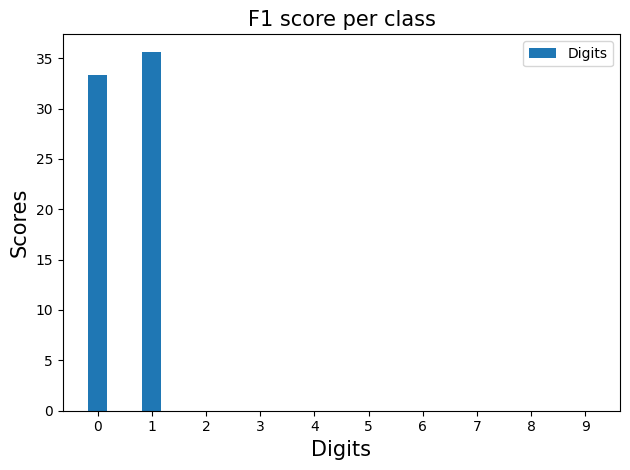

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

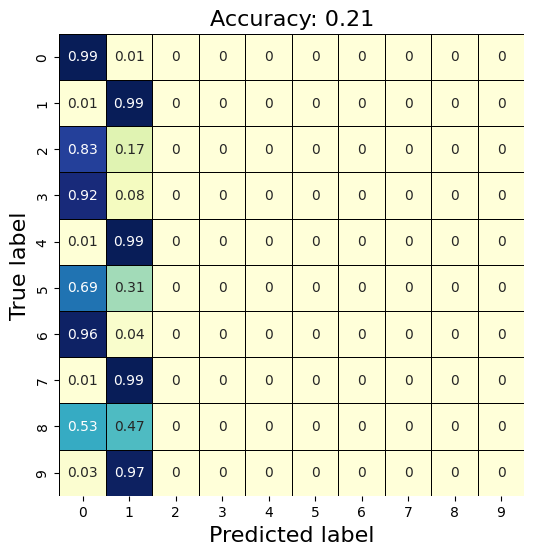

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 5

In [ ]:
y_pred = train_pipeline(3, True)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-4-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


Epoch 1/50
274/274 [==============================] - 4s 8ms/step - loss: 59.1491
Epoch 2/50
274/274 [==============================] - 2s 7ms/step - loss: 52.8001
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7945
Epoch 4/50
274/274 [==============================] - 2s 5ms/step - loss: 52.7853
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7882
Epoch 6/50
274/274 [==============================] - 2s 8ms/step - loss: 52.7859
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7763
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7830
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7769
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7772
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7786
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 52.7748
Epoch 13/50
2

<ipython-input-4-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
<ipython-input-4-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


Training step: alpha[0]: 3.0
3.0
274/274 [==============================] - 6s 10ms/step - loss: 52.7639 - AE__loss: 52.7639 - clustering_loss: 1.4932e-06
Training step: alpha[1]: 3.0
3.0
274/274 [==============================] - 3s 11ms/step - loss: 52.7643 - AE__loss: 52.7643 - clustering_loss: 2.4885e-18
Training step: alpha[2]: 3.0
3.0
274/274 [==============================] - 3s 11ms/step - loss: 52.7631 - AE__loss: 52.7631 - clustering_loss: 1.1272e-18
Training step: alpha[3]: 3.0
3.0
274/274 [==============================] - 3s 11ms/step - loss: 52.7624 - AE__loss: 52.7624 - clustering_loss: 1.0660e-18
Training step: alpha[4]: 3.0
3.0
274/274 [==============================] - 3s 11ms/step - loss: 52.7628 - AE__loss: 52.7628 - clustering_loss: 1.6435e-18
Training step: alpha[5]: 3.0
3.0
274/274 [==============================] - 3s 11ms/step - loss: 52.7610 - AE__loss: 52.7610 - clustering_loss: 1.2437e-18
Training step: alpha[6]: 3.0
3.0
274/274 [============================

<ipython-input-4-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.11253, NMI = 0.00000


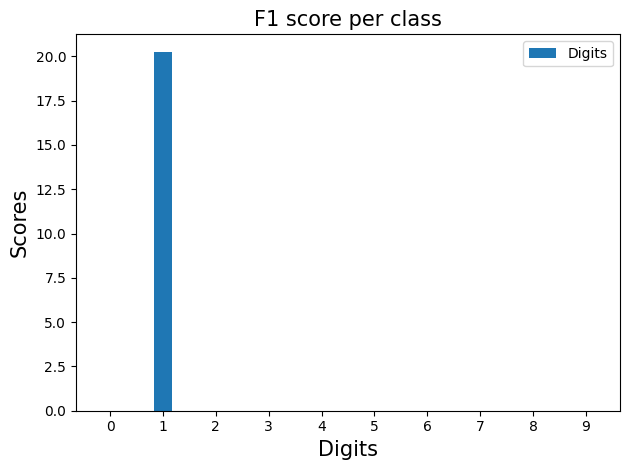

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

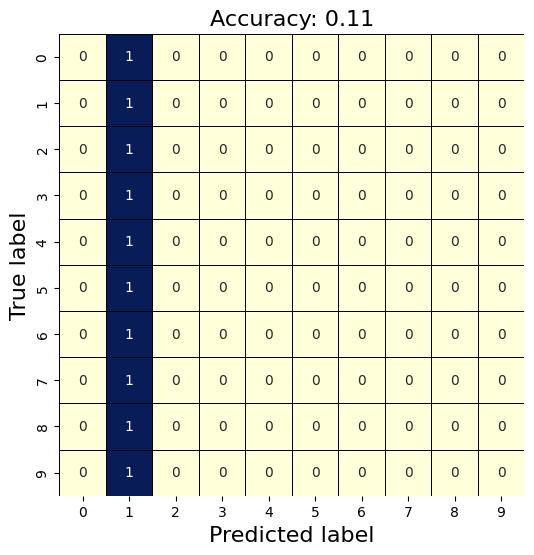

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 6

In [ ]:
y_pred = train_pipeline(30, True)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-4-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 3s 8ms/step - loss: 48.2870
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 40.9471
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 39.2019
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 37.9558
Epoch 5/50
274/274 [==============================] - 2s 7ms/step - loss: 37.2290
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 36.1186
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 32.7881
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 30.0355
Epoch 9/50
274/274 [==============================] - 2s 5ms/step - loss: 28.1758
Epoch 10/50
274/274 [==============================] - 2s 8ms/step - loss: 27.2170
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 26.5624
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 26.1589
Epoch 13/50
274/274 [===

<ipython-input-4-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 30.0
30.0


<ipython-input-4-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 7s 14ms/step - loss: 21.6525 - AE__loss: 21.1942 - clustering_loss: 0.4582
Training step: alpha[1]: 30.0
30.0
274/274 [==============================] - 3s 10ms/step - loss: 21.3923 - AE__loss: 21.0725 - clustering_loss: 0.3198
Training step: alpha[2]: 30.0
30.0
274/274 [==============================] - 3s 11ms/step - loss: 21.2484 - AE__loss: 20.9845 - clustering_loss: 0.2638
Training step: alpha[3]: 30.0
30.0
274/274 [==============================] - 4s 13ms/step - loss: 21.1114 - AE__loss: 20.8819 - clustering_loss: 0.2296
Training step: alpha[4]: 30.0
30.0
274/274 [==============================] - 3s 11ms/step - loss: 21.0019 - AE__loss: 20.7958 - clustering_loss: 0.2061
Training step: alpha[5]: 30.0
30.0
274/274 [==============================] - 3s 10ms/step - loss: 20.8537 - AE__loss: 20.6664 - clustering_loss: 0.1873
Training step: alpha[6]: 30.0
30.0
274/274 [==============================] - 4s 13ms/step - loss: 20.7963 - AE__loss

<ipython-input-4-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.55901, NMI = 0.62692


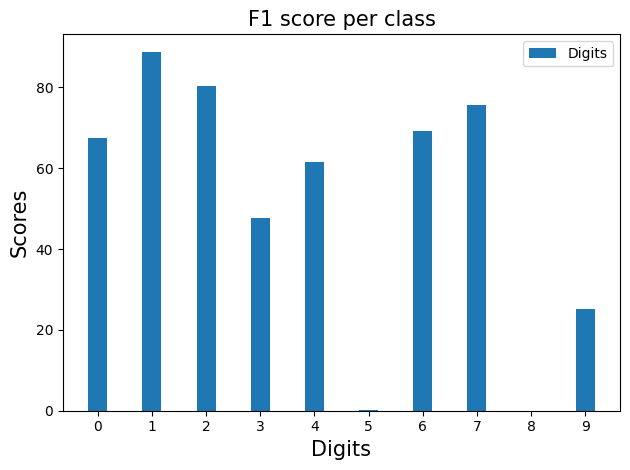

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

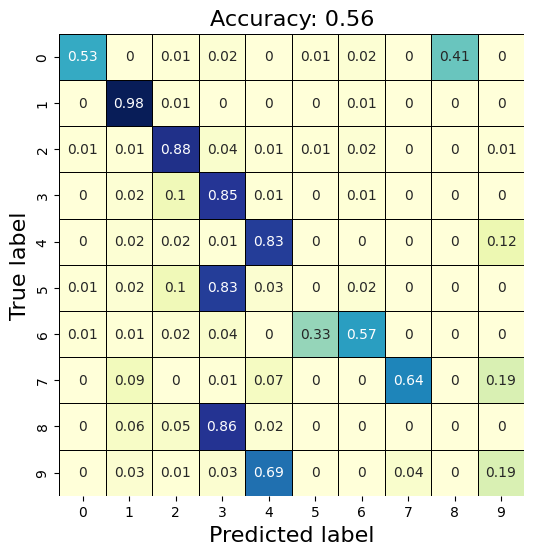

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 7

In [ ]:
y_pred = train_pipeline(150, True)

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-4-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 3s 8ms/step - loss: 53.3891
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 44.8335
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 43.8764
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 43.0753
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 42.1241
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 41.6157
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 40.5493
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 37.6121
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 36.1811
Epoch 10/50
274/274 [==============================] - 2s 8ms/step - loss: 35.5061
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 33.7926
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 31.3481
Epoch 13/50
274/274 [===

<ipython-input-4-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 150.0
150.0


<ipython-input-4-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 6s 10ms/step - loss: 19.9890 - AE__loss: 19.5555 - clustering_loss: 0.4336
Training step: alpha[1]: 150.0
150.0
274/274 [==============================] - 4s 15ms/step - loss: 19.6747 - AE__loss: 19.3742 - clustering_loss: 0.3005
Training step: alpha[2]: 150.0
150.0
274/274 [==============================] - 3s 10ms/step - loss: 19.4420 - AE__loss: 19.1955 - clustering_loss: 0.2466
Training step: alpha[3]: 150.0
150.0
274/274 [==============================] - 3s 10ms/step - loss: 19.2243 - AE__loss: 19.0103 - clustering_loss: 0.2140
Training step: alpha[4]: 150.0
150.0
274/274 [==============================] - 4s 15ms/step - loss: 18.9981 - AE__loss: 18.8077 - clustering_loss: 0.1905
Training step: alpha[5]: 150.0
150.0
274/274 [==============================] - 3s 11ms/step - loss: 18.7890 - AE__loss: 18.6151 - clustering_loss: 0.1739
Training step: alpha[6]: 150.0
150.0
274/274 [==============================] - 3s 11ms/step - loss: 18.560

<ipython-input-4-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.65491, NMI = 0.70186


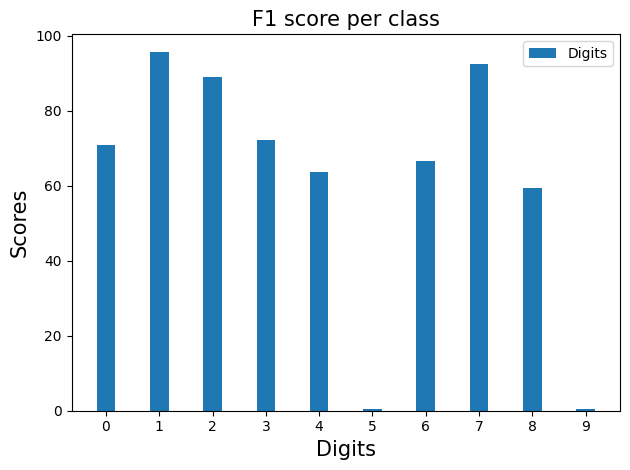

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

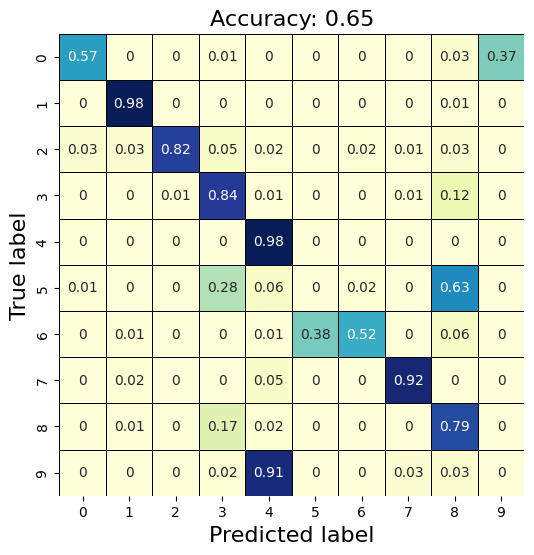

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


### Config. 8


In [ ]:
y_pred = train_pipeline(300, True)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-21-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 3s 7ms/step - loss: 46.7069
Epoch 2/50
274/274 [==============================] - 2s 8ms/step - loss: 34.2872
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 28.6348
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 25.9879
Epoch 5/50
274/274 [==============================] - 1s 5ms/step - loss: 23.9686
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 22.4715
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 21.2492
Epoch 8/50
274/274 [==============================] - 2s 5ms/step - loss: 20.2085
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 19.3057
Epoch 10/50
274/274 [==============================] - 2s 8ms/step - loss: 18.6020
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 18.0178
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 17.5464
Epoch 13/50
274/274 [===

<ipython-input-21-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-21-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 5s 10ms/step - loss: 15.8733 - AE__loss: 14.0224 - clustering_loss: 1.8509
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 14.8626 - AE__loss: 13.8861 - clustering_loss: 0.9764
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 4s 15ms/step - loss: 14.5209 - AE__loss: 13.8012 - clustering_loss: 0.7196
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 14.3113 - AE__loss: 13.7301 - clustering_loss: 0.5812
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 14.1658 - AE__loss: 13.6742 - clustering_loss: 0.4916
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 10ms/step - loss: 14.0693 - AE__loss: 13.6411 - clustering_loss: 0.4282
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 4s 15ms/step - loss: 13.962

<ipython-input-21-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.76056, NMI = 0.68370


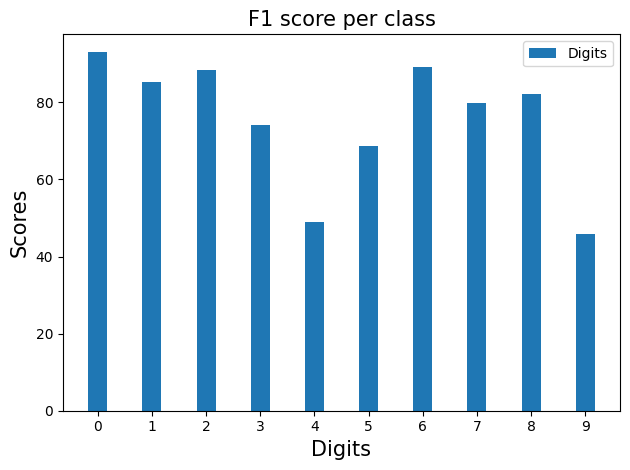

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)

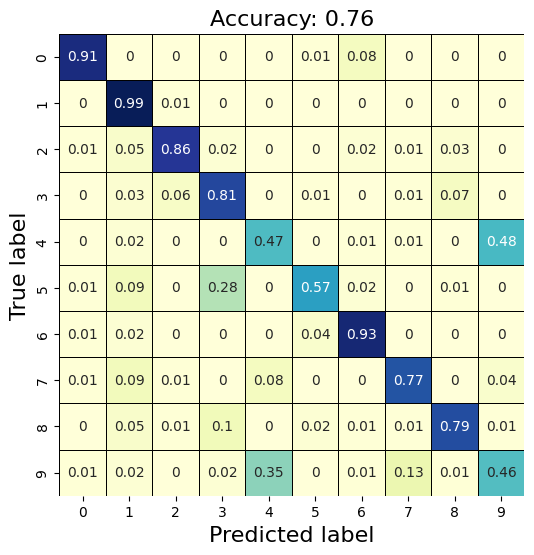

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


## Task 2

### 2 clusters


In [ ]:
y_pred = train_pipeline(300, True, n_clusters=2)

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 2)                 20        
                                                                 
 clustering (Softmax_functi  (None, 2)                 1  

<ipython-input-57-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 2s 6ms/step - loss: 48.7176
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 36.1030
Epoch 3/50
274/274 [==============================] - 2s 7ms/step - loss: 32.7972
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 31.2388
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 28.8274
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 27.4404
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 26.0520
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 24.7953
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 24.1119
Epoch 10/50
274/274 [==============================] - 2s 8ms/step - loss: 23.5397
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 23.1244
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 22.7551
Epoch 13/50
274/274 [===

<ipython-input-57-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-57-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 3s 8ms/step - loss: 19.0264 - AE__loss: 18.2090 - clustering_loss: 0.8174
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 18.5932 - AE__loss: 18.0819 - clustering_loss: 0.5113
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 11ms/step - loss: 18.3947 - AE__loss: 17.9923 - clustering_loss: 0.4024
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 18.2410 - AE__loss: 17.9018 - clustering_loss: 0.3392
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 18.1036 - AE__loss: 17.8080 - clustering_loss: 0.2957
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 17.9947 - AE__loss: 17.7305 - clustering_loss: 0.2643
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 2s 8ms/step - loss: 17.9119 - AE

<ipython-input-57-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.20936, NMI = 0.28797


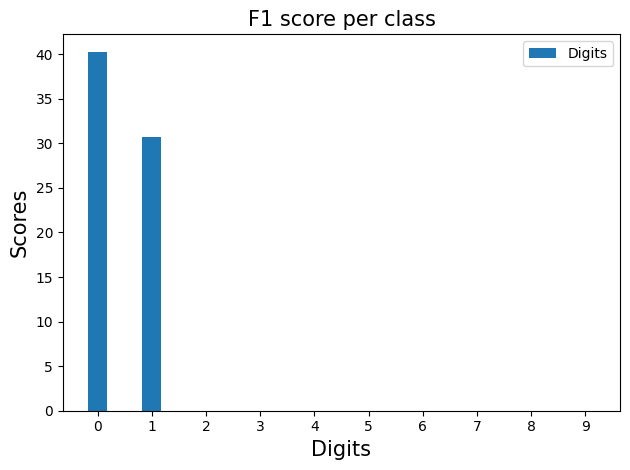

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)


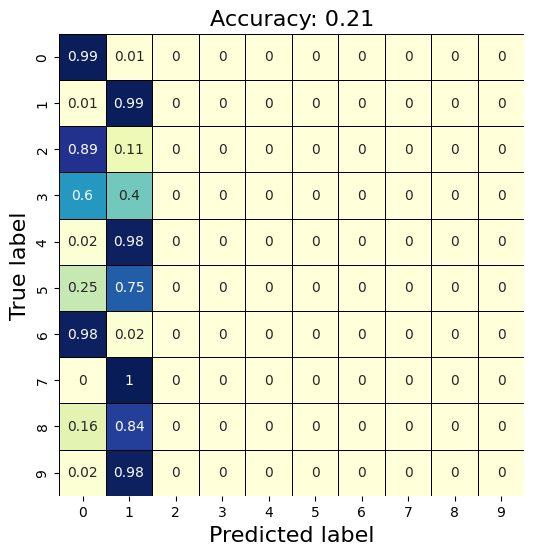

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


[]

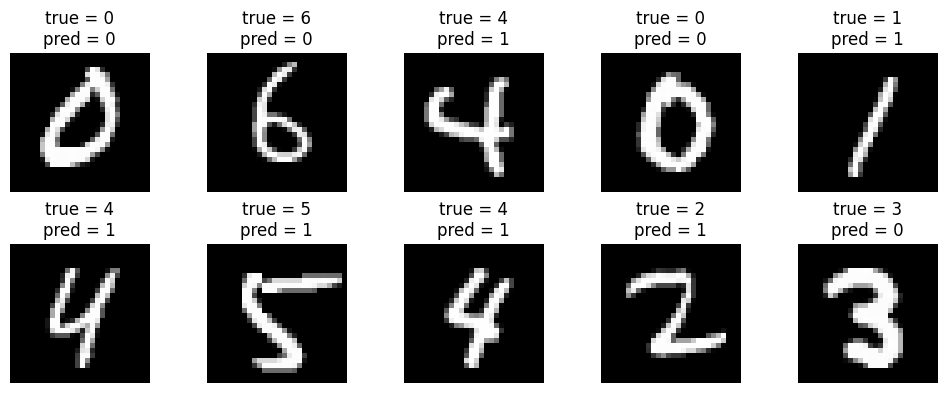

In [ ]:
indices = np.random.permutation(len(y_pred))[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(indices):
    ax = axes.flat[i]
    ax.imshow(x[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"true = {y[idx]}\npred = {y_pred_map[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.plot()

### 5 clusters


In [ ]:
y_pred = train_pipeline(300, True, n_clusters=5)

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 5)                 50        
                                                                 
 clustering (Softmax_functi  (None, 5)                 1  

<ipython-input-57-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 2s 6ms/step - loss: 59.6455
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7929
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7844
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 52.7824
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7849
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7777
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7757
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7782
Epoch 9/50
274/274 [==============================] - 2s 7ms/step - loss: 52.7741
Epoch 10/50
274/274 [==============================] - 2s 8ms/step - loss: 52.7749
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7742
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 52.7798
Epoch 13/50
274/274 [===

<ipython-input-57-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
<ipython-input-57-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


Training step: alpha[0]: 300.0
300.0
274/274 [==============================] - 4s 9ms/step - loss: 52.7620 - AE__loss: 52.7620 - clustering_loss: 1.1684e-06
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 52.7623 - AE__loss: 52.7623 - clustering_loss: 1.9135e-08
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 12ms/step - loss: 52.7615 - AE__loss: 52.7615 - clustering_loss: 6.8522e-09
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 52.7618 - AE__loss: 52.7618 - clustering_loss: 1.0538e-08
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 52.7613 - AE__loss: 52.7613 - clustering_loss: 2.2397e-08
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 2s 9ms/step - loss: 52.7625 - AE__loss: 52.7625 - clustering_loss: 1.4509e-08
Training step: alpha[6]: 300.0
300.0
274/274 [=====

<ipython-input-57-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 4ms/step


Acc = 0.11253, NMI = 0.00000


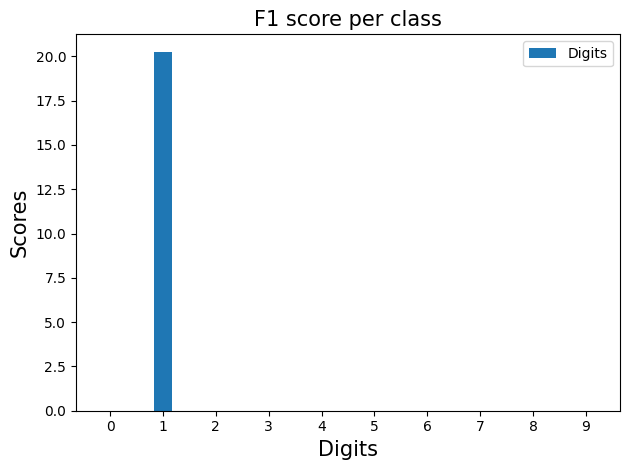

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)


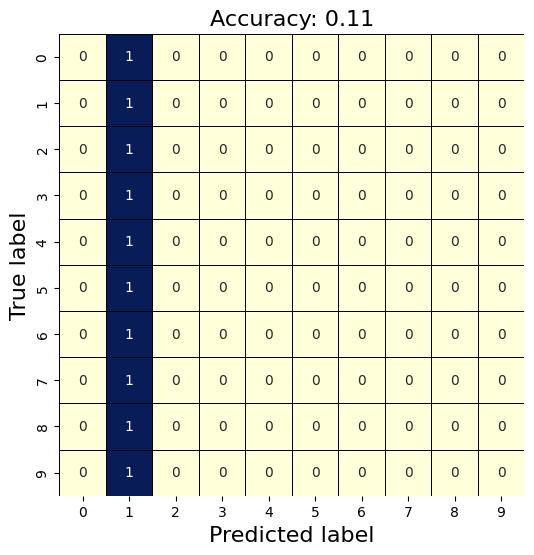

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


[]

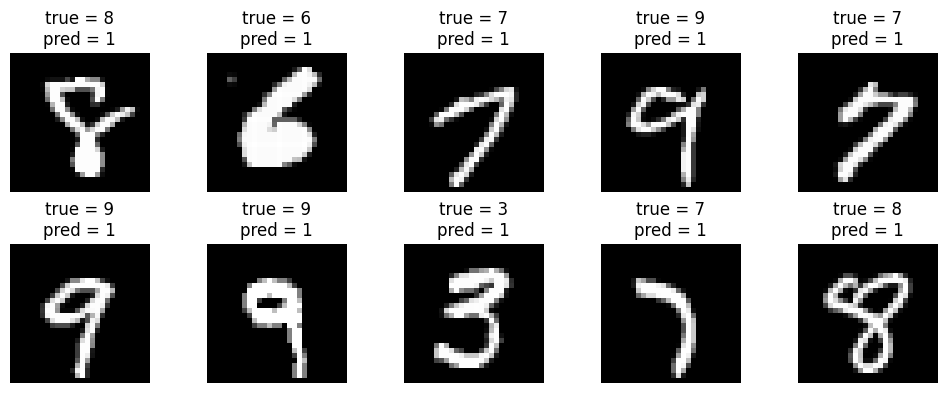

In [ ]:
indices = np.random.permutation(len(y_pred))[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(indices):
    ax = axes.flat[i]
    ax.imshow(x[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"true = {y[idx]}\npred = {y_pred_map[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.plot()

### 10 clusters


In [ ]:
y_pred = train_pipeline(300, True, n_clusters=10)

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 clustering (Softmax_functi  (None, 10)                1  

<ipython-input-57-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 3s 9ms/step - loss: 50.6362
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 44.6931
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 43.9511
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 43.4174
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 42.6477
Epoch 6/50
274/274 [==============================] - 2s 8ms/step - loss: 42.0759
Epoch 7/50
274/274 [==============================] - 2s 7ms/step - loss: 41.7279
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 41.3428
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 41.0097
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 40.8139
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 40.4194
Epoch 12/50
274/274 [==============================] - 2s 7ms/step - loss: 40.2145
Epoch 13/50
274/274 [===

<ipython-input-57-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-57-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 7s 16ms/step - loss: 17.7113 - AE__loss: 17.0189 - clustering_loss: 0.6924
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 3s 11ms/step - loss: 17.3694 - AE__loss: 16.9239 - clustering_loss: 0.4456
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 3s 12ms/step - loss: 17.2175 - AE__loss: 16.8609 - clustering_loss: 0.3565
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 17.0956 - AE__loss: 16.7910 - clustering_loss: 0.3046
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 3s 12ms/step - loss: 16.9884 - AE__loss: 16.7201 - clustering_loss: 0.2684
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 3s 11ms/step - loss: 16.8698 - AE__loss: 16.6297 - clustering_loss: 0.2401
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 4s 16ms/step - loss: 16.810

<ipython-input-57-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.68306, NMI = 0.65795


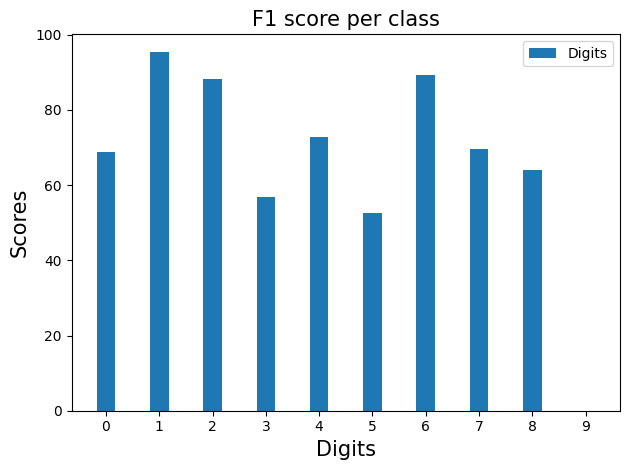

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)


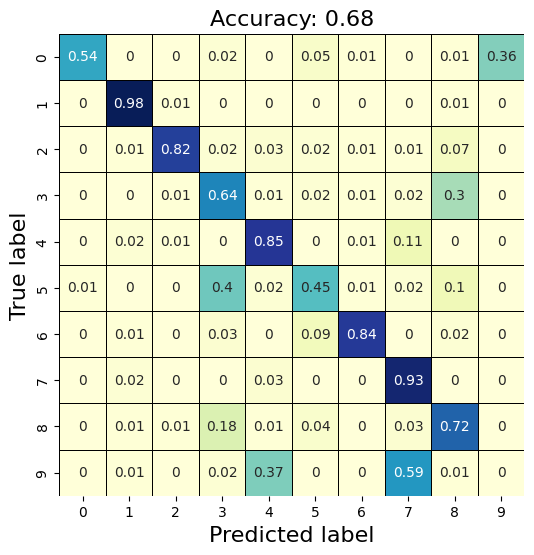

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


[]

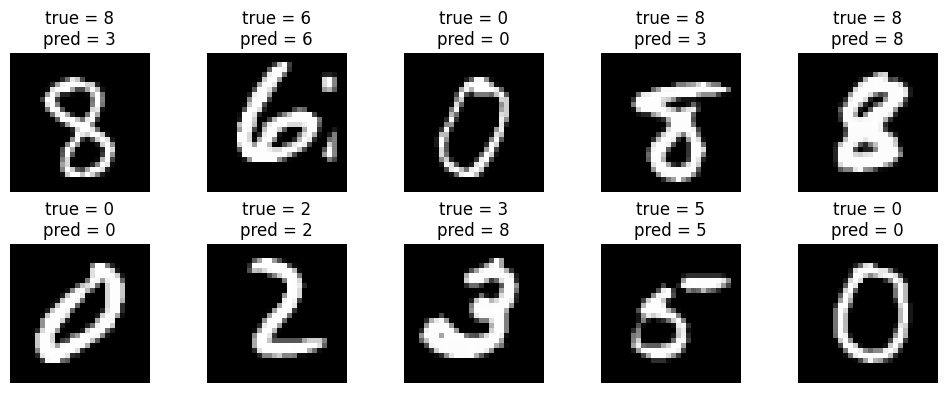

In [ ]:
indices = np.random.permutation(len(y_pred))[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(indices):
    ax = axes.flat[i]
    ax.imshow(x[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"true = {y[idx]}\npred = {y_pred_map[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.plot()

### 20 clusters


In [ ]:
y_pred = train_pipeline(300, True, n_clusters=20)

Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 20)                200       
                                                                 
 clustering (Softmax_functi  (None, 20)                1  

<ipython-input-57-1fb957880bee>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs=num_epochs_AE)


274/274 [==============================] - 3s 10ms/step - loss: 48.8442
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 39.9839
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 34.3337
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 31.9678
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 30.3524
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 28.1096
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 27.0627
Epoch 8/50
274/274 [==============================] - 2s 8ms/step - loss: 26.4826
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 26.0683
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 25.7052
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 25.4336
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 25.2165
Epoch 13/50
274/274 [==

<ipython-input-57-1fb957880bee>:19: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training step: alpha[0]: 300.0
300.0


<ipython-input-57-1fb957880bee>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs=num_epochs_per_alpha)


274/274 [==============================] - 10s 20ms/step - loss: 22.4775 - AE__loss: 22.0347 - clustering_loss: 0.4428
Training step: alpha[1]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 22.3316 - AE__loss: 22.0149 - clustering_loss: 0.3166
Training step: alpha[2]: 300.0
300.0
274/274 [==============================] - 5s 19ms/step - loss: 22.2391 - AE__loss: 21.9788 - clustering_loss: 0.2602
Training step: alpha[3]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 22.1439 - AE__loss: 21.9202 - clustering_loss: 0.2238
Training step: alpha[4]: 300.0
300.0
274/274 [==============================] - 4s 14ms/step - loss: 22.1245 - AE__loss: 21.9260 - clustering_loss: 0.1985
Training step: alpha[5]: 300.0
300.0
274/274 [==============================] - 5s 20ms/step - loss: 22.0813 - AE__loss: 21.9010 - clustering_loss: 0.1803
Training step: alpha[6]: 300.0
300.0
274/274 [==============================] - 6s 20ms/step - loss: 22.05

<ipython-input-57-1fb957880bee>:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


Acc = 0.50613, NMI = 0.44402


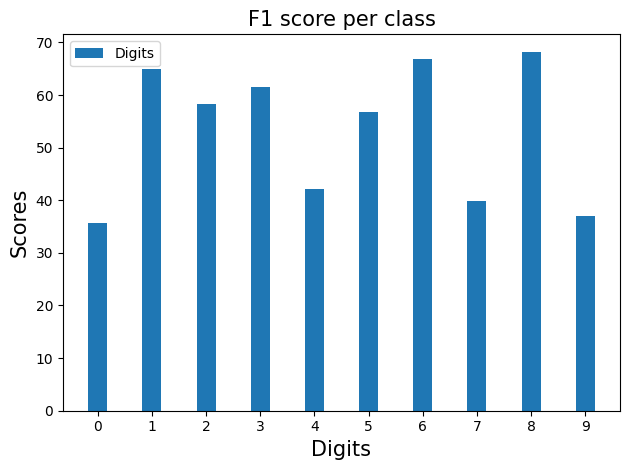

In [ ]:
y_pred_map = assignment_cluster(y, y_pred)
acc, nmi, f1score = calculate_evaluation_metrics(y, y_pred_map)

print('Acc = %.5f, NMI = %.5f' % (acc, nmi))

plot_f1_score_per_class(f1score)


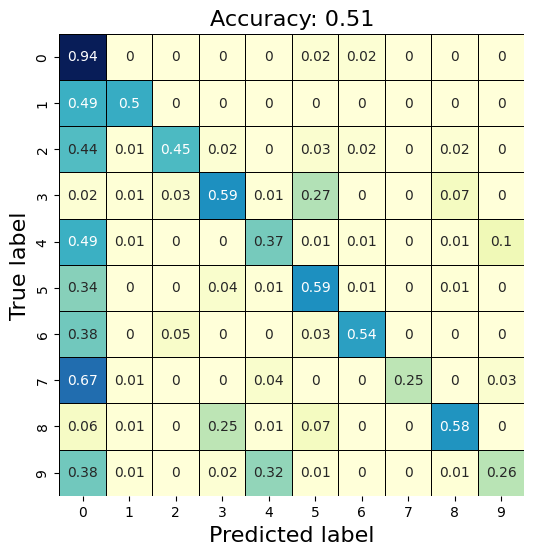

In [ ]:
plot_confusion_heatmap(y, y_pred_map)


[]

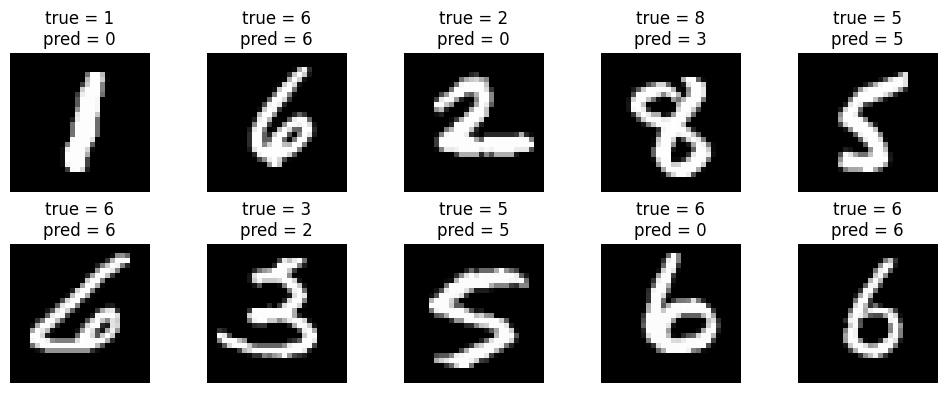

In [ ]:
indices = np.random.permutation(len(y_pred))[:10]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(indices):
    ax = axes.flat[i]
    ax.imshow(x[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"true = {y[idx]}\npred = {y_pred_map[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.plot()